In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
transform = transforms.ToTensor()

In [23]:
train_data = datasets.CIFAR10(root = '/Users/elifseven/Desktop/PytorchUdemy/Data',train=True,download=True,transform = transform)

Files already downloaded and verified


In [24]:
test_data = datasets.CIFAR10(root = '/Users/elifseven/Desktop/PytorchUdemy/Data',train=False,download=True,transform = transform)

Files already downloaded and verified


In [25]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /Users/elifseven/Desktop/PytorchUdemy/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [26]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: /Users/elifseven/Desktop/PytorchUdemy/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [28]:
torch.manual_seed(101);
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [30]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [32]:
for images,labels in train_loader:
    break

In [34]:
labels

tensor([7, 3, 8, 7, 2, 8, 4, 9, 6, 7])

Label:  [7 3 8 7 2 8 4 9 6 7]
Class:  horse   cat  ship horse  bird  ship  deer truck  frog horse


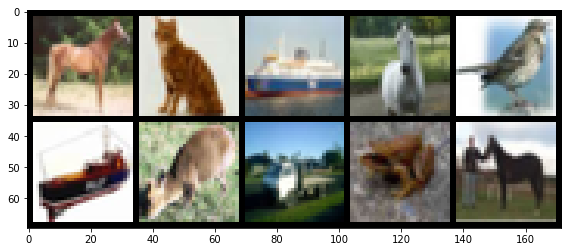

In [39]:
#Print the label names.
print('Label: ',labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images,nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [40]:
#If you were to try to run an artifical neural network on this it
#would basically fail because you can see here these images from one to other look very different.
#And the fact they are colored just adds another layet of complexity that really the articical neural network would not able.
#So, we need to do use it convolution network

In [66]:
# CREATE Convolutional network CLASS MODEL

#input channel is 3, because we have color images.
#we have 6 filters
#we choose 5*5 kernel or it can be 4*4..
#stride is default 1

#Conv2:
#it's receiving 6 because we had six filters in the prev. conv layer
#16, there is an arbitrary number of filters for my conv
#3*3 image kernel
#1 is default stride

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
        
#why 6*6*16: we recall that previously we had 4*4*16 there was MNIST
#So, that was when we had 32*32 images with 3*3 filters,
#so we have now 6*6*16 because, 

In [67]:
images[0].shape

#3 color channels, each of these 32*32

torch.Size([3, 32, 32])

In [68]:
(((32-2)/2)-2)/2

#-2 because we have no padding


6.5

In [69]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [70]:
for param in model.parameters():
    print(param.numel())
    
#sum of all these: 82302

162
6
864
16
69120
120
10080
84
840
10


In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [72]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.67938364  accuracy:  27.040%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.88542724  accuracy:  33.215%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.90334511  accuracy:  36.830%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.41259456  accuracy:  39.185%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.39102399  accuracy:  41.160%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.25814950  accuracy:  51.350%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.32738841  accuracy:  51.785%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.20816410  accuracy:  52.227%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.24417186  accuracy:  52.540%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 2.19242835  accuracy:  52.940%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.32332683  accuracy:  56.690%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.69817317  accuracy:  57.095%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 0.81319273  accuracy:  57.213%
epoch:  2  b

In [73]:
torch.save(model.state_dict(),'myCIFARmodel.pt')

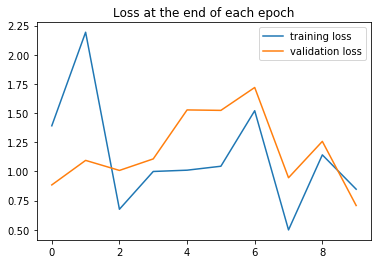

In [74]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [75]:
# EVALUATE TEST DATA

print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(4891), tensor(5481), tensor(5728), tensor(5912), tensor(6008), tensor(6098), tensor(6054), tensor(6133), tensor(6154), tensor(6110)]

Test accuracy: 61.100%


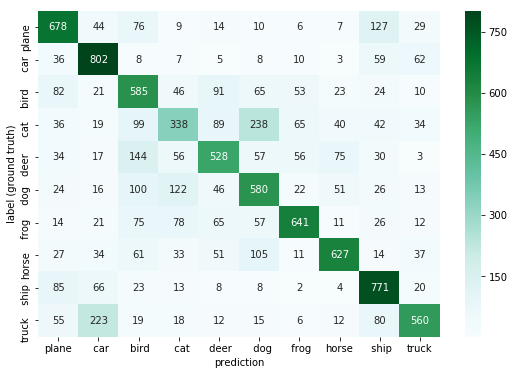

In [76]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

# x axis we have the actual prediction
# this darker line along the diagonal, its means correct predictions

